### Classification of MNIST digits from sound

##### Data information:

We have a dataset of `8800` spoken digits, encoded as a time series of `13` Mel-frequency cepstral coefficients. 


###### Train Set:

Filename: `Train_Arabic_Digits.txt`

Each block delimited by an empty line corresponds to a one analysis frame which consist of `4-93` lines of `13 MEL` coefficients.

The first `330` blocks correspond to male speakers, the next `330` are spoken by females.

Block `1-660` correspond to the digit `0`, `661-1320` to the digit `1`, etc.

In summary we should have `6600` test data samples.

###### Test Set:

Filename: `Test_Arabic_Digits.txt`

Same as the training set, except we have only `220` for each digit, the first `110` are spoken by males, and the other `110` by females.

In summary we should have `2200` test data samples.


Link to the [data source](http://archive.ics.uci.edu/ml/datasets/Spoken+Arabic+Digit).

In [2]:
%matplotlib inline

import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import operator
import functools
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


In [3]:
# index to track how many samples we've seen for the current class
s_ix   = 0

trainings_set_raw = [[]]

with open('Train_Arabic_Digits.txt', 'r') as file:
    for lineix, line in enumerate(file):
        if line.isspace():
            s_ix += 1
            trainings_set_raw.append([])
        else:
            coeffs = [float(s) for s in line.split(' ')]
            trainings_set_raw[s_ix].append(coeffs)

s_ix   = 0

test_set_raw = [[]]

with open('Test_Arabic_Digits.txt', 'r') as file:
    for lineix, line in enumerate(file):
        if line.isspace():
            s_ix += 1
            test_set_raw.append([])
        else:
            coeffs = [float(s) for s in line.split(' ')]
            test_set_raw[s_ix].append(coeffs)


In [4]:
# as the samples have different length, we will clip them to the smallest size

def check_timestep_size(dataset):
    min_len = sys.maxsize
    max_len = 0
    for sample in range(1,len(dataset)):
        cur_len = len(dataset[sample])
        if  cur_len < min_len:
            min_len = cur_len
        if  cur_len > max_len:
            max_len = cur_len

    print('Smallest timestep size: {0} for {1} samples'.format(min_len, len(dataset)))
    print('Greatest timestep size: {0} for {1} samples'.format(max_len, len(dataset)))
    
check_timestep_size(trainings_set_raw)
check_timestep_size(test_set_raw)

Smallest timestep size: 4 for 6600 samples
Greatest timestep size: 93 for 6600 samples
Smallest timestep size: 7 for 2200 samples
Greatest timestep size: 83 for 2200 samples


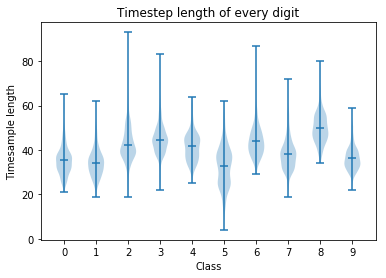

In [8]:
# let's see the distribution of the length

training_set_lengths = list(map(lambda l: len(l), trainings_set_raw))
zeros  = training_set_lengths[1:660]
ones   = training_set_lengths[661:1320]
twos   = training_set_lengths[1321:1980]
threes = training_set_lengths[1981:2640]
fours  = training_set_lengths[2641:3300]
fives  = training_set_lengths[3301:3960]
sixs   = training_set_lengths[3961:4620]
sevens = training_set_lengths[4621:5220]
eights = training_set_lengths[5281:5940]
nines  = training_set_lengths[5941:6600]

fig = plt.violinplot([zeros, ones, twos, threes, fours, fives, sixs, sevens, eights, nines]
                     , range(0,10)
                     , showmeans=True)
plt.title('Timestep length of every digit')
plt.xticks(range(0,10))
plt.xlabel('Class')
plt.ylabel('Timesample length')
plt.show()

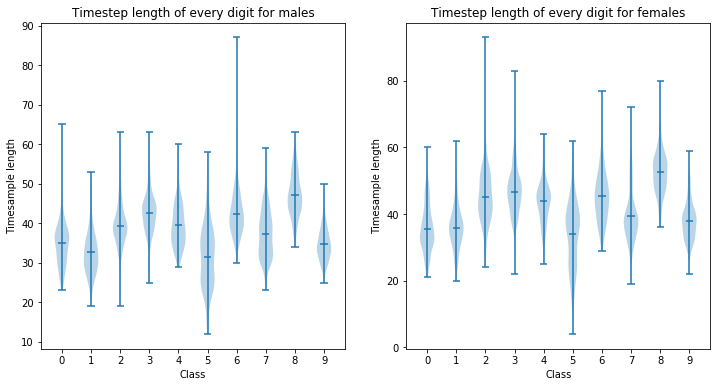

In [9]:
# Gender analysis

zeros_m  = zeros[1:330]
zeros_f  = zeros[331:660]

ones_m  = ones[1:330]
ones_f  = ones[331:660]

twos_m  = twos[1:330]
twos_f  = twos[331:660]

threes_m  = threes[1:330]
threes_f  = threes[331:660]

fours_m  = fours[1:330]
fours_f  = fours[331:660]

fives_m  = fives[1:330]
fives_f  = fives[331:660]

sixs_m  = sixs[1:330]
sixs_f  = sixs[331:660]

sevens_m  = sevens[1:330]
sevens_f  = sevens[331:660]

eights_m  = eights[1:330]
eights_f  = eights[331:660]

nines_m  = nines[1:330]
nines_f  = nines[331:660]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

axes[0].violinplot([zeros_m, ones_m, twos_m, threes_m, fours_m, fives_m, sixs_m, sevens_m, eights_m, nines_m]
                     , range(0,10)
                     , showmeans=True)
axes[0].set_title('Timestep length of every digit for males')
axes[0].set_xticks(range(0,10))
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Timesample length')

axes[1].violinplot([zeros_f, ones_f, twos_f, threes_f, fours_f, fives_f, sixs_f, sevens_f, eights_f, nines_f]
                     , range(0,10)
                     , showmeans=True)
axes[1].set_title('Timestep length of every digit for females')
axes[1].set_xticks(range(0,10))
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Timesample length')

plt.show()


In [235]:
# we will append zeros to every sample until it each one reaches 93 timesteps

def add_zero_padding(dataset):
    
    zero_padding = [0.] * 13
    
    for ix in range(1,len(dataset)):
        while len(dataset[ix]) < 93:
            dataset[ix].append(zero_padding)

add_zero_padding(trainings_set_raw)
add_zero_padding(test_set_raw)

# let's check the sizes again
check_timestep_size(trainings_set_raw)
check_timestep_size(test_set_raw)

Smallest timestep size: 93 for 6600 samples
Greatest timestep size: 93 for 6600 samples
Smallest timestep size: 93 for 6600 samples
Greatest timestep size: 93 for 6600 samples


In [239]:
# now we will flatten the timesteps so every sample will have a dimension of 93*13

def flatten_set(dataset):
    is_flattened = True
    new_dataset  = [0] * len(dataset)
    
    for ix in range(1, len(dataset)):
        new_dataset[ix] = functools.reduce(operator.add, dataset[ix])
        is_flattened &= len(new_dataset[ix]) == 93 * 13
            
    print('Everything is flattened: {0}'.format(is_flattened))
    return new_dataset
    
trainings_set = flatten_set(trainings_set_raw)
test_set      = flatten_set(test_set_raw)

Everything is flattened: True
Everything is flattened: True


In [278]:
# now we have the create the target labels
trainings_set_targets_raw = [ [0] * 660, [1] * 660, [2] * 660, [3] * 660, [4] * 660, [5] * 660, [6] * 660, [7] * 660, [8] * 660, [9] * 660 ]
test_set_targets_raw      = [ [0] * 220, [1] * 220, [2] * 220, [3] * 220, [4] * 220, [5] * 220, [6] * 220, [7] * 220, [8] * 220, [9] * 220]

# flatten them
trainings_set_targets = [item for sublist in trainings_set_targets_raw for item in sublist]
test_set_targets = [item for sublist in test_set_targets_raw for item in sublist]

print('Trainingsize - X: {0}, Y:{1}'.format(len(trainings_set),len(trainings_set_targets)))
print('Testsize     - X: {0}, Y:{1}'.format(len(test_set),len(test_set_targets)))


Trainingsize - X: 6600, Y:6600
Testsize     - X: 2200, Y:2200


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

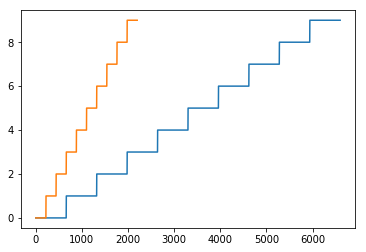

In [279]:
plt.plot(trainings_set_targets)
plt.plot(test_set_targets)

# somehow the first element is a zero, we just duplicate to test the classifier
trainings_set[0] = trainings_set[1]
test_set[0]      = test_set[1]

classifier = KNeighborsClassifier(n_neighbors=10, weights='uniform', algorithm='auto')
classifier.fit(trainings_set, trainings_set_targets)

In [283]:
# now we trained our classifer - let's see the accuracy (this may take some time)
test_prediction = classifier.predict(test_set)
accuracy = accuracy_score(test_set_targets, test_prediction)
print('Accuracy: {0}%'.format(accuracy*100))

Accuracy: 96.22727272727273%


In [340]:
# let's see first-hand

for ix in range(1,20):
    print('Should be 0: {0}'.format(classifier.predict(np.array(test_set[ix]).reshape(1,-1))))
print()

for ix in range(240,260):
    print('Should be 1: {0}'.format(classifier.predict(np.array(test_set[ix]).reshape(1,-1))))
print()

for ix in range(460,480):
    print('Should be 2: {0}'.format(classifier.predict(np.array(test_set[ix]).reshape(1,-1))))
print()

for ix in range(690,710):
    print('Should be 3: {0}'.format(classifier.predict(np.array(test_set[ix]).reshape(1,-1))))
print()

for ix in range(900,920):
    print('Should be 4: {0}'.format(classifier.predict(np.array(test_set[ix]).reshape(1,-1))))
print()
    
for ix in range(1150,1170):
    print('Should be 5: {0}'.format(classifier.predict(np.array(test_set[ix]).reshape(1,-1))))
print()
    
for ix in range(1350,1370):
    print('Should be 6: {0}'.format(classifier.predict(np.array(test_set[ix]).reshape(1,-1))))
print()
    
for ix in range(1600,1620):
    print('Should be 7: {0}'.format(classifier.predict(np.array(test_set[ix]).reshape(1,-1))))
print()

for ix in range(1780,1800):
    print('Should be 8: {0}'.format(classifier.predict(np.array(test_set[ix]).reshape(1,-1))))
print()

for ix in range(1980,2000):
    print('Should be 9: {0}'.format(classifier.predict(np.array(test_set[ix]).reshape(1,-1))))
print()

Should be 0: [0]
Should be 0: [0]
Should be 0: [0]
Should be 0: [0]
Should be 0: [0]
Should be 0: [0]
Should be 0: [7]
Should be 0: [7]
Should be 0: [0]
Should be 0: [0]
Should be 0: [0]
Should be 0: [0]
Should be 0: [0]
Should be 0: [0]
Should be 0: [0]
Should be 0: [0]
Should be 0: [0]
Should be 0: [0]
Should be 0: [0]

Should be 1: [1]
Should be 1: [1]
Should be 1: [1]
Should be 1: [1]
Should be 1: [1]
Should be 1: [1]
Should be 1: [1]
Should be 1: [1]
Should be 1: [1]
Should be 1: [1]
Should be 1: [1]
Should be 1: [1]
Should be 1: [1]
Should be 1: [1]
Should be 1: [1]
Should be 1: [1]
Should be 1: [1]
Should be 1: [1]
Should be 1: [1]
Should be 1: [1]
Should be 2: [2]
Should be 2: [2]
Should be 2: [2]
Should be 2: [2]
Should be 2: [2]
Should be 2: [2]
Should be 2: [2]
Should be 2: [2]
Should be 2: [2]
Should be 2: [2]
Should be 2: [2]
Should be 2: [2]
Should be 2: [2]
Should be 2: [2]
Should be 2: [2]
Should be 2: [2]
Should be 2: [2]
Should be 2: [2]
Should be 2: [2]
Should be 2: 